##  Elman's RNN
## Pablo Valdunciel Sánchez 
## 8th December, 2019

# Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data preparation

In [36]:
def split_sequence(sequence, n_steps):
    X = []
    Y = []
    num_records = len(sequence) - n_steps

    for i in range(num_records):
        X.append(sequence[i:i+n_steps])
        Y.append(sequence[i+n_steps])
        
    return np.array(X),np.array(Y)

In [37]:
SEQ_LEN = 20 
HOLD_OUT = 0.66
X_MAX = 15 

# Read file containing the stock values 
data = pd.read_excel('./data/historica Iberdrola DIC 16-19.xls', dtype={'Fecha': str, 'Último': float}).values 

# Reverse the data set so that most ancient values go first 
data = np.flip(data, axis=0)

# Separate dates and stock_vales
dates = data[:,0]
stock_values = data[:,1]

# Split the sequence
X,Y = split_sequence(stock_values, SEQ_LEN)

# Scale the stock_values 
X = X / X_MAX 
Y = Y / X_MAX 

# Get train and test sets (Holdout)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-HOLD_OUT), random_state=2) 

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(475, 20) (245, 20) (475,) (245,)


# Elman RNN class

In [44]:
# -----------------------------------------------------------------------------
# Elman reccurent network
# Copyright (C) 2011  Nicolas P. Rougier
#
# Distributed under the terms of the BSD License.
# -----------------------------------------------------------------------------
# This is an implementation of the multi-layer perceptron with retropropagation
# learning.
# -----------------------------------------------------------------------------

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - x**2

class ElmanRNN:
    """Elman's Recurrente Neural Network class"""
    
    def __init__(self, layer_sizes, epochs=100, alpha=0.01, momentum=0.01, verbose=False):
        """Intialize the recurrent neural network"""
        
        if (len(layer_sizes) != 3):
            raise AttributeError("len(layer_sizes) != 3")
            
        self.__layer_sizes = layer_sizes
        self.__epochs = epochs 
        self.__alpha = alpha 
        self.__momentum = momentum
        self.__verbose = verbose 
        
        # Layers 
        self.__N = []
        self.__N.append(np.ones(self.__layer_sizes[0] + 1 + self.__layer_sizes[1]))
        self.__N.append(np.ones(self.__layer_sizes[1]))
        self.__N.append(np.ones(self.__layer_sizes[2]))
        
        # Weights matrix 
        self.__W = []
        self.__W.append(np.zeros((self.__N[0].size, self.__N[1].size)))
        self.__W.append(np.zeros((self.__N[1].size, self.__N[2].size)))
        self.__dw = [0,] * len(self.__W)        
        self.__init_weights()
        
        # History 
        self.__epochs_history = []
        self.__losses_history = []
        
        print(self)
      
    @property
    def epochs_history(self):
        return self.__epochs_history
    
    @property 
    def losses_history(self):
        return self.__losses_history
    
    
    def __str__(self):
        return "ElmanRNN(layer_sizes={}, epochs={}, alpha={}, momentum={}, verbose={})".format(self.__layer_sizes,self.__epochs,self.__alpha, self.__momentum, self.__verbose)
        
    def __init_weights(self):
        """Initialize the weights matrix W"""
        
        for i in range(len(self.__W)):
            r = np.random.random((self.__N[i].size, self.__N[i+1].size))
            self.__W[i][...] = (2*r-1)*0.25
            
            
    def __propagate_forward(self, x):
        """Propagate the inpunt vector to the output layer"""
        
        # Input
        self.__N[0][:self.__layer_sizes[0]] = x 
        # Recurrent connections 
        self.__N[0][self.__layer_sizes[0]:-1] = self.__N[1]
        
        # Propagate forward
        self.__N[1] = tanh(np.dot(self.__N[0], self.__W[0]))
        self.__N[2] = tanh(np.dot(self.__N[1], self.__W[1]))
        
        return self.__N[2]
        
        
    def __propagate_backward(self, y):
        """Apply the delta rule to modify the weights"""
        
        deltas = []
        
        # Output layer's error
        err = y - self.__N[2]
        delta = err * dtanh(self.__N[2])
        deltas.append(delta)
        
        # Hidden layer's error 
        delta = np.dot(deltas[0], self.__W[1].T)  * dtanh(self.__N[1])
        deltas.insert(0, delta)
        
        # Weights modification
        for i in range(len(self.__W)):
            layer = np.atleast_2d(self.__N[i])
            delta = np.atleast_2d(deltas[i])
            delta_w = np.dot(layer.T, delta)
            self.__W[i] += self.__alpha * delta_w + self.__momentum * self.__dw[i]
            self.__dw[i] = delta_w
            
        loss = (err**2).sum()
        
        return loss 
        
        
    def fit(self, X, Y):
        """Fit the network with the instances X and their labels Y"""
        
        for epoch in range(self.__epochs):
            for i in range(X.shape[0]):
                output = self.__propagate_forward(X[i])
                loss = self.__propagate_backward(Y[i])
            
            self.__epochs_history.append(epoch)
            self.__losses_history.append(loss)
            
            if (self.__verbose):
                print("-Epoch {}, loss = {}".format(epoch, loss))
        
        
    def predict(self, X):
        """Compute the output for every instance of X"""

        outputs = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):              
            outputs[i] = self.__propagate_forward(X[i])
        
        return outputs
    
    
    def evaluate(self, X, Y, margin = 0.03):
        """Compute the accuracy of the network over the X data set"""
            
        predictions = self.predict(X)
        hits = 0
        
        for i in range(X.shape[0]):            
            if abs(predictions[i] - Y[i]) <= margin: 
                hits += 1
        
        return hits / Y.shape[0]       
            

# Class testing

In [39]:
MAX_ITERATION = 100
MARGIN = 0.03

### Create and fit network

In [40]:
elman = ElmanRNN(layer_sizes=[SEQ_LEN,7,1], epochs=MAX_ITERATION, alpha=0.2, momentum=0.01,  verbose=False)
elman.fit(x_train, y_train)

ElmanRNN(layer_sizes=[20, 7, 1], epochs=100, alpha=0.2, momentum=0.01, verbose=False)


### Show loss evolution

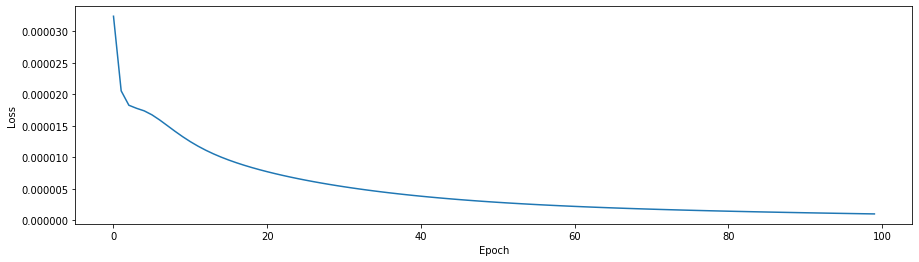

In [41]:
losses = elman.losses_history
epochs = elman.epochs_history

fig = plt.figure(figsize=(15,4))
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Predict and evaluate

In [42]:
predictions = elman.predict(x_test)
hit_rate = elman.evaluate(x_test, y_test, margin=MARGIN)

print("Hit rate (relative error <= {}) = {}".format(MARGIN, hit_rate ))

Hit rate (relative error <= 0.03) = 0.9959183673469387


### Comparation

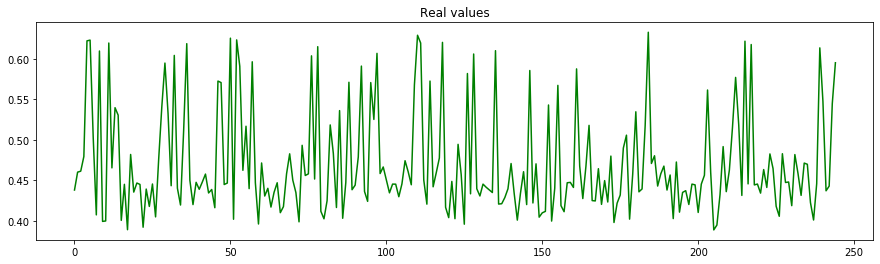

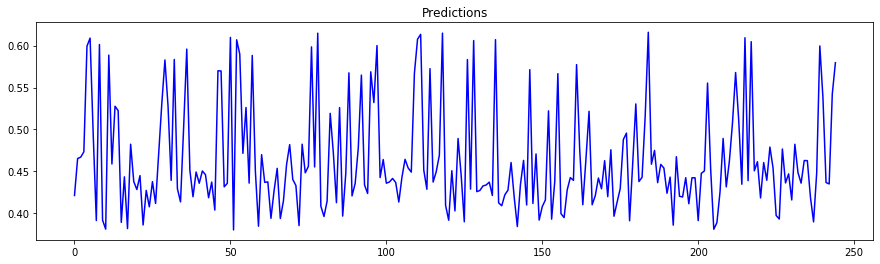

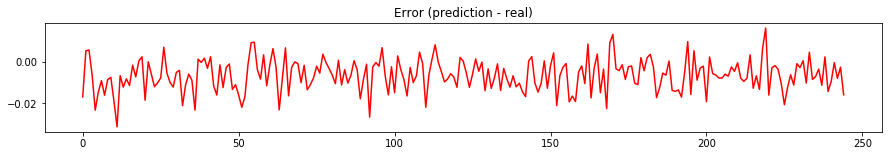

In [43]:
fig = plt.figure(figsize=(15,4))
x = range(len(predictions))
plt.plot(x, y_test, 'green')
plt.title("Real values")
plt.show()

fig = plt.figure(figsize=(15,4))
plt.plot(x, predictions, 'blue')
plt.title("Predictions")
plt.show()

fig = plt.figure(figsize=(15,2))
plt.plot(x, predictions-y_test, 'red')
plt.title("Error (prediction - real)")
plt.show()